# Cancer Classifier
Notebook by Jim Arnold

## Executive Summary

Using a Gradient Boosted Classifier in combination with SMOTE, trained a model capabile of acheiving 99% AUROC using only two features.

Exploration of feature importance of the provided data reveals Clump Thickness, Uniformity of Cell Size, Bare Nuclei are capable of differentiating 'benign' and 'malignant' cases.

Given limited time and resources, recommend collecting the following data from incoming samples (in order of decreasing importance):

Uniformity of Cell Size > Clump Thickness > Bare Nuclei > Bland Chromatin > all others.

Data should be submitted by pathologist or technician into online app, which will generate probabilities of the sample belonging to either class, as well as an explaination of the features which contributed to that classification. This is available through the ELI5 package.

## Introduction

You belong to the data team at a local research hospital. You've been tasked with
developing a means to help doctors diagnose breast cancer. You've been given data
about biopsied breast cells; where it is benign (not harmful) or malignant (cancerous).
1. What features of a cell are the largest drivers of malignancy?
2. How would a physician use your product?
3. There is a non­zero cost in time and money to collect each feature about a given
cell. How would you go about determining the most cost­effective method of
detecting malignancy?

### Feature Definitions

The dataset contains the following features for each cell:
- Sample code number: id number
- Clump Thickness: 1 ­ 10
- Uniformity of Cell Size: 1 ­ 10
- Uniformity of Cell Shape: 1 ­ 10
- Marginal Adhesion: 1 ­ 10
- Single Epithelial Cell Size: 1 ­ 10
- Bare Nuclei: 1 ­ 10
- Bland Chromatin: 1 ­ 10
- Normal Nucleoli: 1 ­ 10
- Mitoses: 1 ­ 10
- Class: (2 for benign, 4 for malignant)

## Prepare Data

In [1]:
# Standard DS stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# set plot defaults
sns.set(context='notebook', style='white')

In [2]:
# Import dataset(s) here, or connect to SQL
df = pd.read_csv('breast-cancer-wisconsin.txt')

### Cleaning

In [5]:
# inspect df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15855 non-null int64
ID                             15855 non-null int64
Clump Thickness                15855 non-null int64
Uniformity of Cell Size        15827 non-null object
Uniformity of Cell Shape       15827 non-null object
Marginal Adhesion              15827 non-null object
Single Epithelial Cell Size    15827 non-null object
Bare Nuclei                    15827 non-null object
Bland Chromatin                15827 non-null object
Normal Nucleoli                15827 non-null object
Mitoses                        15827 non-null object
Class                          15827 non-null object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB


Appears some missingness, several features are objects. Likely some records are not 1-10 per definitions provided.

In [7]:
# inspect Class, this is what I'll be using to train classifier, should only be 2 or 4
df.Class.value_counts()

4          15164
2            456
40           151
?             23
No idea       17
#             11
20             5
Name: Class, dtype: int64

Several mislabled entries. To avoid complication, I'm going to drop all rows not 2 or 4.

In [3]:
df2 = df[df.Class.isin(['2','4'])]

In [10]:
# reinspect Class, this is what I'll be using to train classifier, should only be 2 or 4
df2.Class.value_counts()

4    15164
2      456
Name: Class, dtype: int64

In [11]:
# looks good, now check type and missingness
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15620 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15620 non-null int64
ID                             15620 non-null int64
Clump Thickness                15620 non-null int64
Uniformity of Cell Size        15620 non-null object
Uniformity of Cell Shape       15620 non-null object
Marginal Adhesion              15620 non-null object
Single Epithelial Cell Size    15620 non-null object
Bare Nuclei                    15620 non-null object
Bland Chromatin                15620 non-null object
Normal Nucleoli                15620 non-null object
Mitoses                        15620 non-null object
Class                          15620 non-null object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB


There is complete data for all the remaining records. Next, check what's driving the object typing.

In [13]:
df2['Uniformity of Cell Size'].value_counts()

10    4048
6     4005
5     2020
8     2018
3     1047
4     1033
9     1003
1      382
2       45
7       19
Name: Uniformity of Cell Size, dtype: int64

should be dtype int64... maybe there's extra data somewhere?

In [45]:
df2.shape

(15620, 12)

In [4]:
# maybe it's already fixed, try type conversion
df2['Uniformity of Cell Size'] = df2['Uniformity of Cell Size'].astype('int64')

/home/jim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# check type
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15620 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15620 non-null int64
ID                             15620 non-null int64
Clump Thickness                15620 non-null int64
Uniformity of Cell Size        15620 non-null int64
Uniformity of Cell Shape       15620 non-null object
Marginal Adhesion              15620 non-null object
Single Epithelial Cell Size    15620 non-null object
Bare Nuclei                    15620 non-null object
Bland Chromatin                15620 non-null object
Normal Nucleoli                15620 non-null object
Mitoses                        15620 non-null object
Class                          15620 non-null object
dtypes: int64(4), object(8)
memory usage: 1.5+ MB


### Fix dtype

In [64]:
# define func to cast all feature columns as int64

# get features and class labels in df
feats = df2.loc[:, 'Clump Thickness':'Class']

# iterate through cols, converting type
for i in feats.columns:
    print(i)
    feats[i] = feats[i].astype('float64')
    print('done')

Clump Thickness
done
Uniformity of Cell Size
done
Uniformity of Cell Shape
done
Marginal Adhesion
done
Single Epithelial Cell Size
done
Bare Nuclei


ValueError: could not convert string to float: '?'

### drop / convert unexpected values

In [38]:
# caught issue with Bare Nuclei, inspect
feats['Bare Nuclei'].value_counts()

10    5106
8     3006
3     2019
5     2016
1     1394
2     1027
6     1000
4       19
?       16
9        9
7        8
Name: Bare Nuclei, dtype: int64

In [65]:
# replace '?' with np.nan
feats['Bare Nuclei'].replace(to_replace='?', value=np.nan, inplace=True)

In [66]:
# try converting again
for i in feats.columns:
    print(i)
    feats[i] = feats[i].astype('float64')
    print('done')

Clump Thickness
done
Uniformity of Cell Size
done
Uniformity of Cell Shape
done
Marginal Adhesion
done
Single Epithelial Cell Size
done
Bare Nuclei
done
Bland Chromatin
done
Normal Nucleoli
done
Mitoses
done
Class
done


In [41]:
# check type:
feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15620 entries, 0 to 15854
Data columns (total 10 columns):
Clump Thickness                15620 non-null float64
Uniformity of Cell Size        15620 non-null float64
Uniformity of Cell Shape       15620 non-null float64
Marginal Adhesion              15620 non-null float64
Single Epithelial Cell Size    15620 non-null float64
Bare Nuclei                    15604 non-null float64
Bland Chromatin                15620 non-null float64
Normal Nucleoli                15620 non-null float64
Mitoses                        15620 non-null float64
Class                          15620 non-null float64
dtypes: float64(10)
memory usage: 1.3 MB


In [67]:
# drop cols with missing values
feats.dropna(inplace=True, axis=0)
feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15604 entries, 0 to 15854
Data columns (total 10 columns):
Clump Thickness                15604 non-null float64
Uniformity of Cell Size        15604 non-null float64
Uniformity of Cell Shape       15604 non-null float64
Marginal Adhesion              15604 non-null float64
Single Epithelial Cell Size    15604 non-null float64
Bare Nuclei                    15604 non-null float64
Bland Chromatin                15604 non-null float64
Normal Nucleoli                15604 non-null float64
Mitoses                        15604 non-null float64
Class                          15604 non-null float64
dtypes: float64(10)
memory usage: 1.3 MB


In [68]:
# check remaining classes
feats.Class.value_counts()

4.0    15162
2.0      442
Name: Class, dtype: int64

In [63]:
# calculate ratio of benign to malign
100*442/15162

2.915182693576045

Almost 100 mal : 3 ben 

Data is highly imbalanced. will need to keep in mind going forward.

## EDA

### Data Viz

Goal is to develop tool to help doctors diagnose breast cancer (benign vs malignant). So, first, which features are differential between benign and malignant. 

First, to aid in viz, I'm going to relabel Class for clarity. Then, I'm going to apply sns.pairplot to visualize the existing features and look for any correlations / distinguishing features.

In [69]:
# relabel Classes
feats['Class'] = feats['Class'].map({2.0: 'benign', 4.0: 'malignant'})
feats['Class'].value_counts()

malignant    15162
benign         442
Name: Class, dtype: int64

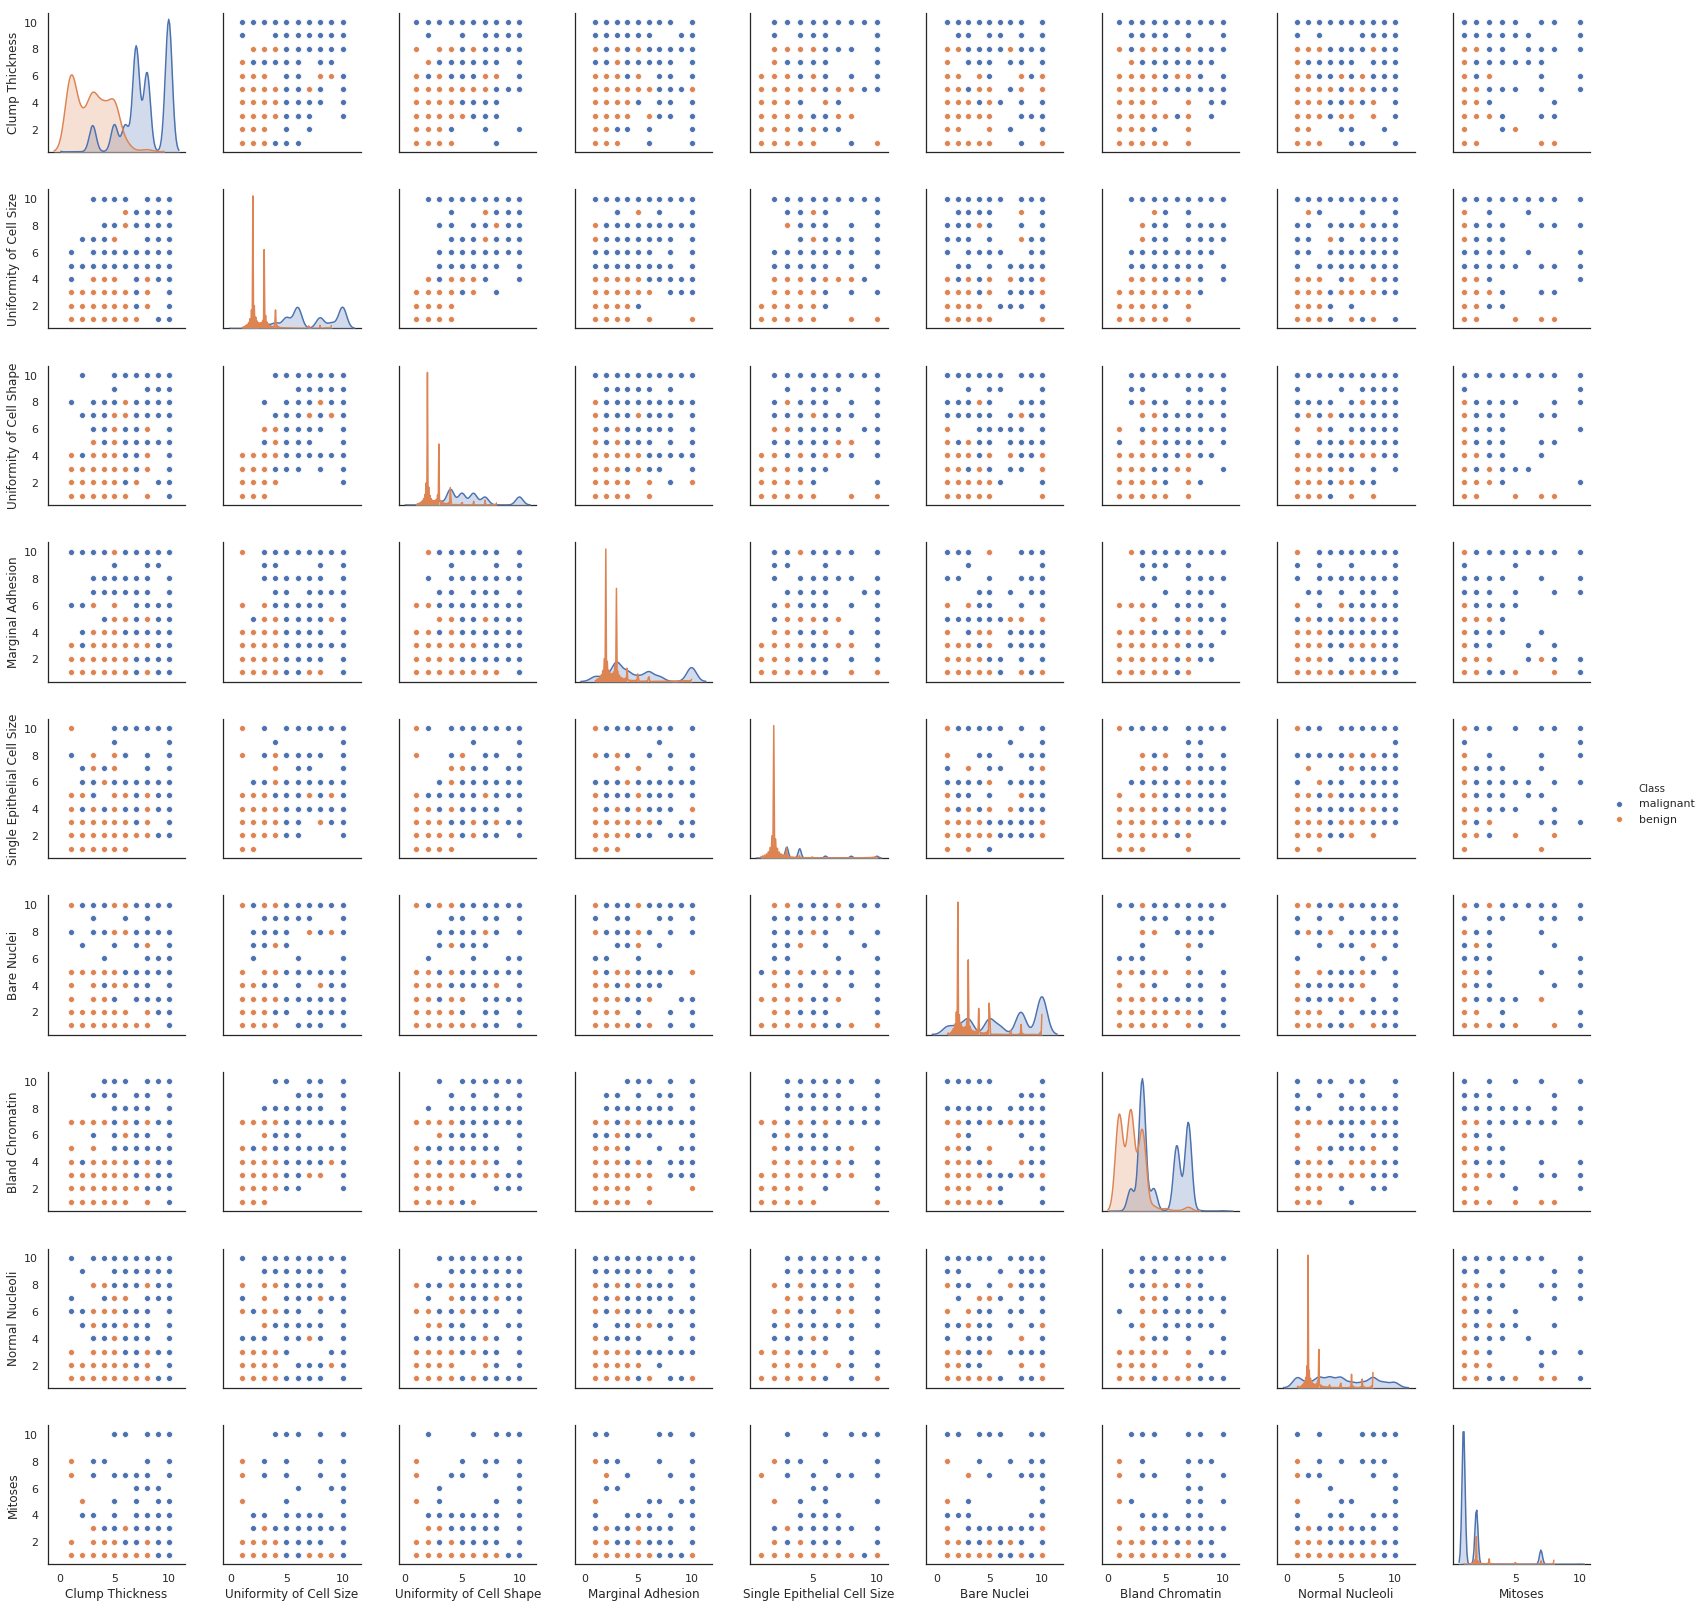

In [54]:
# viz features
sns.pairplot(data=feats, hue='Class')

There's a lot of data here, but based on the diagonals it looks like 
- Clump Thickness
- Uniformity of Cell Size
- Uniformity of Cell Shape 

look very promising. However, Uniformity of Cell Size and Uniformity of Cell Shape might be correlated, so maybe we only need to use one of those. I'm not going to throw anything out yet, but it's good to be mindful.

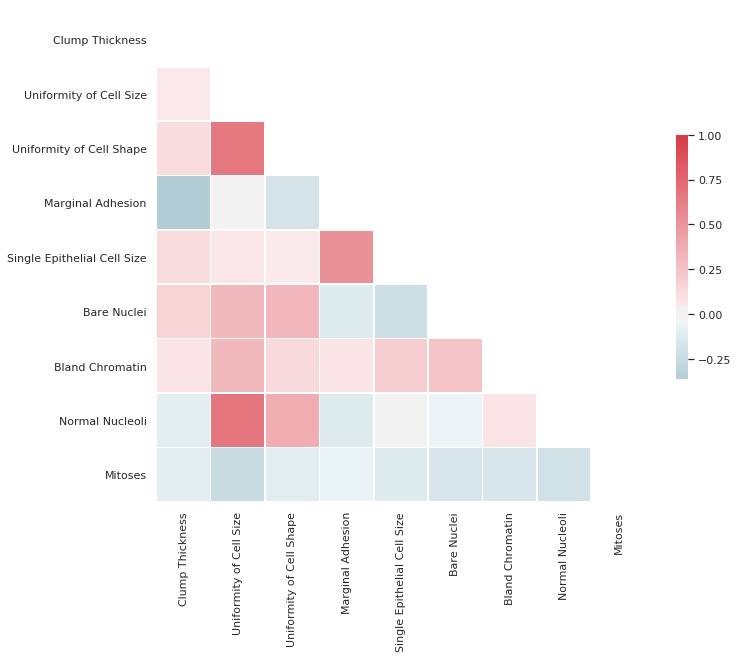

In [82]:
# check correlation status
corr = feats.drop(['Class'], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There's strong correlation between Size vs. Shape and Size vs. Normal Nuclei. May drop Size later.

### SMOTE
Because the data is so imbalanced, I'm going to generate some artificial minority class data using SMOTE and re-run the pairplot.

In [55]:
# optional
#!pip install imblearn

    100% |████████████████████████████████| 174kB 2.5MB/s ta 0:00:01


In [70]:
from imblearn.over_sampling import SMOTE
# define labels (y) and features (X)
y = feats['Class'].values
X = feats.drop(['Class'], axis=1).values

# call SMOTE, use defauls first
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [11]:
# verify
pd.Series(y_res).value_counts()

benign       15162
malignant    15162
dtype: int64

AImbalance be gone! I SMOTE thee!

### pairplot redux

In [71]:
# Kinda clunky, can be streamlined. pairplot required df, so recast values as df
df_sm = pd.DataFrame(X_res, columns=feats.drop(['Class'], axis=1).columns)
df_sm['Class'] = y_res
df_sm.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,7.0,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,malignant
1,6.0,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,malignant
2,8.0,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,malignant
3,7.0,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,malignant
4,5.0,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,malignant


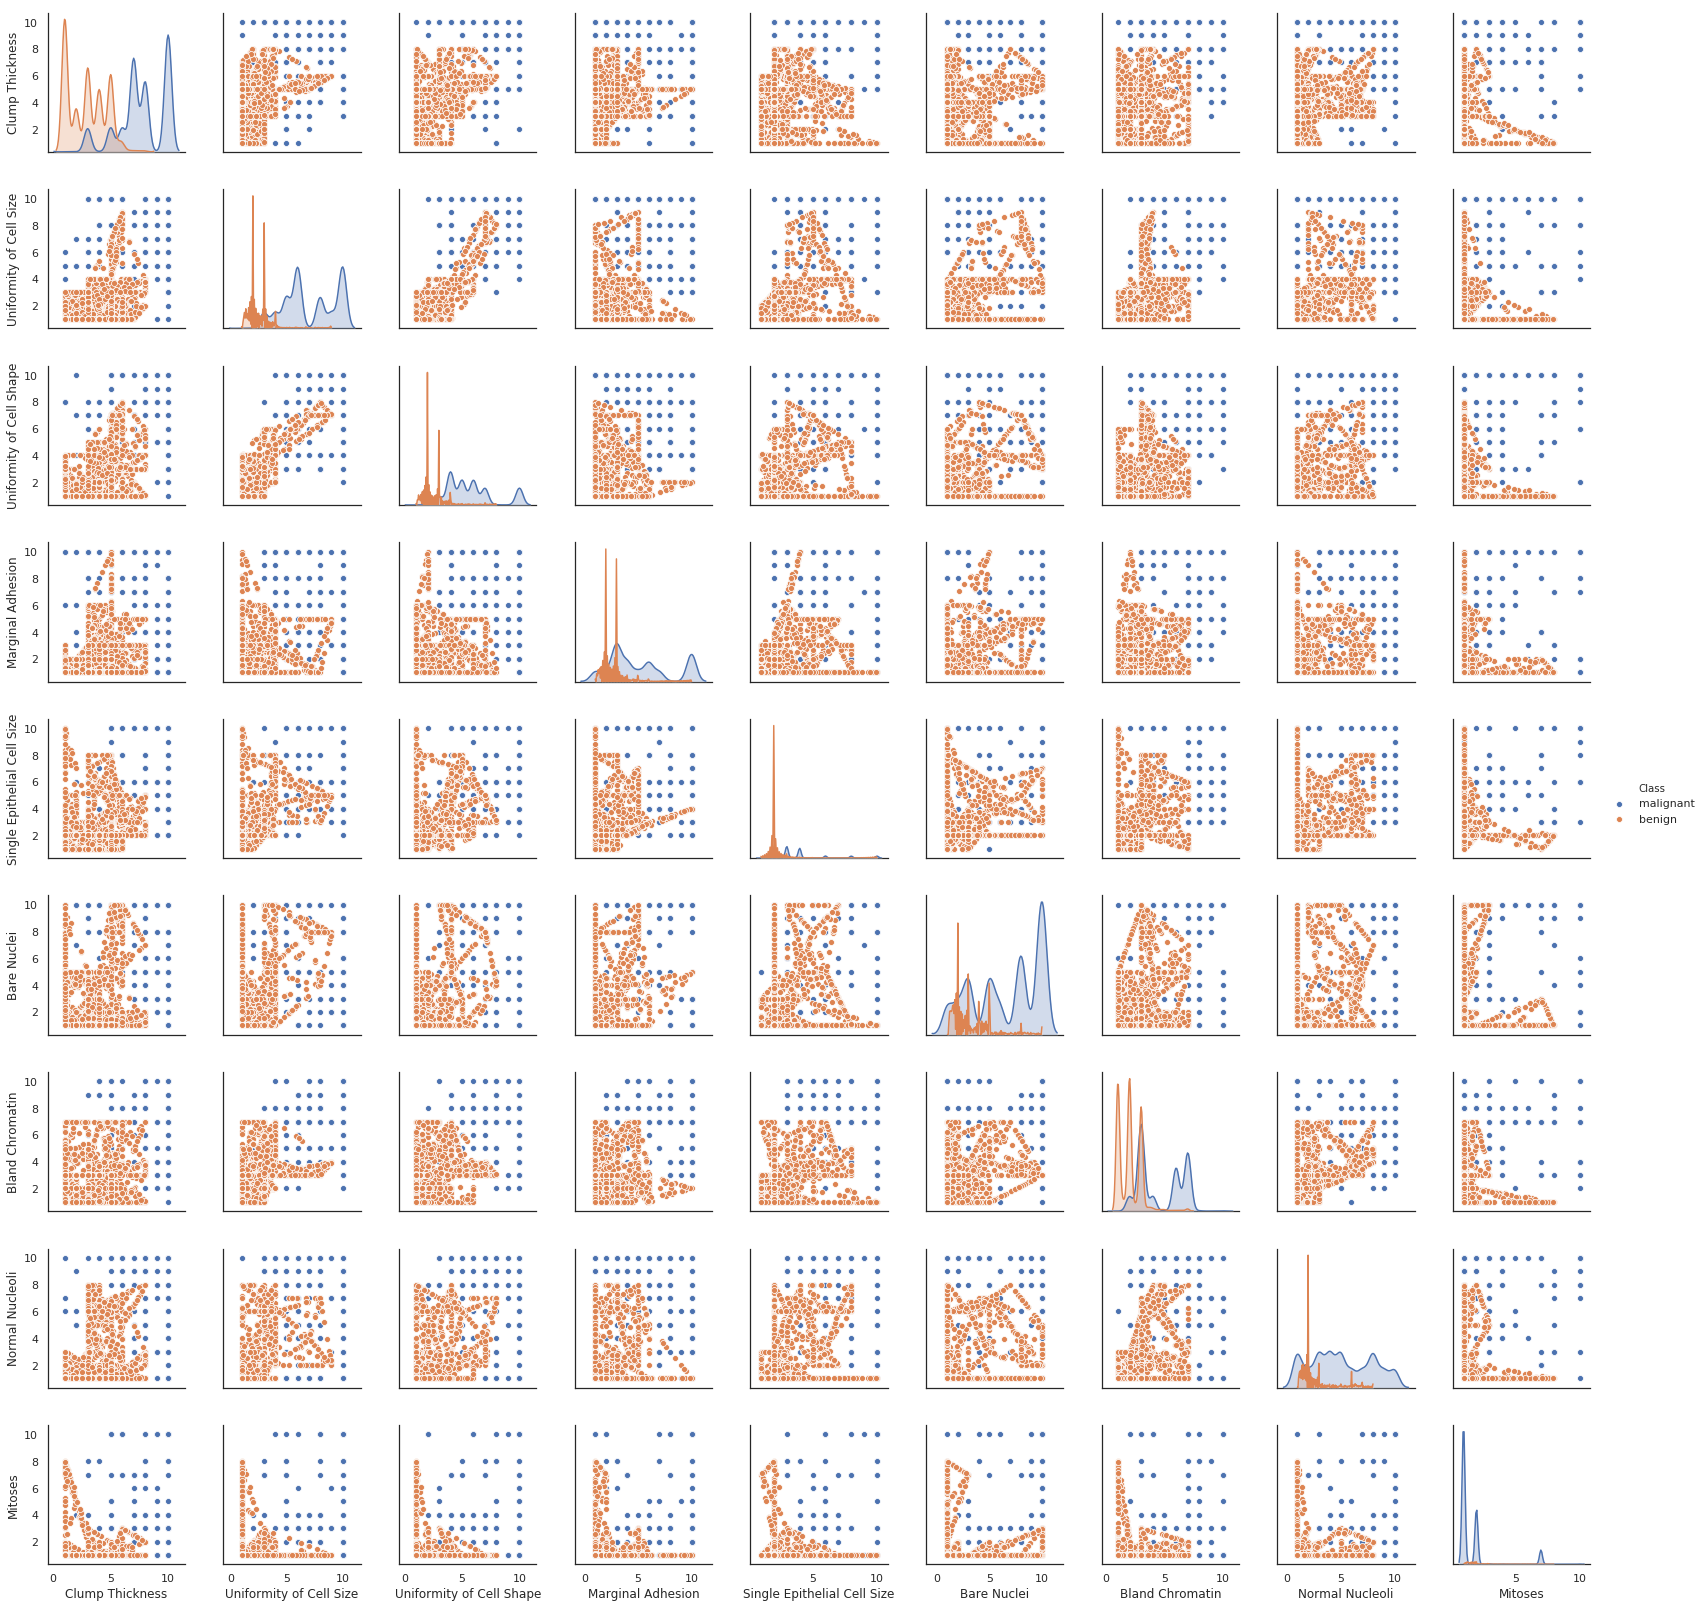

In [78]:
# viz features after SMOTE
sns.pairplot(data=df_sm, hue='Class')

Initial ideas still hold true. Let's try a random forest classifier. 

## Analysis/Modeling

In [92]:
# run auto-sklearn for initial model selection
#!pip install auto-sklearn

    100% |████████████████████████████████| 3.4MB 1.9MB/s ta 0:00:01
    100% |████████████████████████████████| 4.9MB 1.7MB/s ta 0:00:01
    100% |████████████████████████████████| 114.0MB 436kB/s ta 0:00:011
    100% |████████████████████████████████| 286kB 1.8MB/s ta 0:00:011
    100% |████████████████████████████████| 890kB 3.1MB/s ta 0:00:011
    100% |████████████████████████████████| 296kB 2.6MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 3.3MB/s a 0:00:011
  Using cached https://files.pythonhosted.org/packages/4a/bd/eee1157fc2d8514970b345d69cb9975dcd1e42cd7e61146ed841f6e68309/typing-3.6.6-py3-none-any.whl
    100% |████████████████████████████████| 6.4MB 2.7MB/s ta 0:00:011
  Stored in directory: /home/jim/.cache/pip/wheels/89/fb/f5/2f04d19502c1ad8e0706f925ff824de8d5628349c642599f24
  Stored in directory: /home/jim/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5203
  Stored in directory: /home/jim/.cache/pip/wheels/75/83/cb/28dd42ba

  Stored in directory: /home/jim/.cache/pip/wheels/12/52/83/d2d66a840968025d072ddb1cd776fdc5eb5e337e1cc887bc3f
Successfully built auto-sklearn liac-arff ConfigSpace pynisher smac
Failed to build pyrfr
imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
  Running setup.py install for pyrfr ... error
    Complete output from command /home/jim/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-uwgr4xnt/pyrfr/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-record-kudocwth/install-record.txt --single-version-externally-managed --compile:
    running install
    running build_ext
    building 'pyrfr._regression' extension
    swigging pyrfr/re

In [72]:
from sklearn.preprocessing import LabelEncoder
# labelEncode Classes
le = LabelEncoder()
y_res_le = le.fit_transform(y_res)
print(le.classes_)
print(y_res_le[:10])

['benign' 'malignant']
[1 1 1 1 1 1 1 1 1 1]


### Auto-sklearn -  this was not run, but can be

 try autosklearn for model selection
#from sklearn.model_selection import train_test_split
#import autosklearn.classification
#from sklearn import metrics

 train/test 70/30 split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res_le, test_size=0.3, random_state=42)

 fit models
autocls = autosklearn.classification.AutoSklearnClassifier()
autocls.fit(X_train, y_train)
y_pred = autocls.predict(X_test)

 Print the classification report
target_names = ['benign', 'malignant']
print('AUC:',metrics.roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred,target_names=target_names))

In [12]:
# fit GB Classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

# train/test 70/30 split data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res_le, test_size=0.3, random_state=42)

# fit model
clf = GradientBoostingClassifier(random_state=42)  # optimize later
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Print the classification report
target_names = ['benign', 'malignant']
print('AUC:', metrics.roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

/home/jim/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AUC: 0.9987953437778601
             precision    recall  f1-score   support

     benign       1.00      1.00      1.00      4485
  malignant       1.00      1.00      1.00      4613

avg / total       1.00      1.00      1.00      9098



That looks too good to be true. Let's run CV.

In [13]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_res, y_res_le, cv=5, scoring='roc_auc')
print("AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC: 1.00 (+/- 0.00)


Wow, that's looks too good. I mean, there's clear separation in the EDA, but I've never seen 100% AUC before.

In [14]:
# Ideally, the results need to be delivered as probabilities, not absolutes.
clf.predict_proba(X_test)

array([[1.03649404e-03, 9.98963506e-01],
       [1.26422509e-03, 9.98735775e-01],
       [9.99543677e-01, 4.56323262e-04],
       ...,
       [9.99633239e-01, 3.66761133e-04],
       [2.13070721e-03, 9.97869293e-01],
       [9.94212148e-01, 5.78785163e-03]])

## Results

Given the classifier is perfect, let's see which features are driving the classifier.

In [16]:
# optional
#!pip install eli5

    100% |████████████████████████████████| 102kB 1.5MB/s a 0:00:01
  Using cached https://files.pythonhosted.org/packages/c2/fd/202954b3f0eb896c53b7b6f07390851b1fd2ca84aa95880d7ae4f434c4ac/tabulate-0.8.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/1f/e2/ef2581b5b86625657afd32030f90cf2717456c1d2b711ba074bf007c0f1a/graphviz-0.10.1-py2.py3-none-any.whl
  Stored in directory: /home/jim/.cache/pip/wheels/2b/67/89/414471314a2d15de625d184d8be6d38a03ae1e983dbda91e84
Successfully built tabulate


### ELI5 - Permutations to estimate feature importance. 

ELI5 - permute features in classifier and see what produces the biggest drop in accuracy. Those are the most important features to the model.

PermutationImportance(estimator, scoring=None, n_iter=5, random_state=None, cv='prefit', refit=True)

In [17]:
# get feature importances using permutation
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feats.drop(
    ['Class'], axis=1).columns.tolist())

Weight,Feature
0.0881 ± 0.0048,Bare Nuclei
0.0392 ± 0.0028,Uniformity of Cell Size
0.0149 ± 0.0016,Normal Nucleoli
0.0142 ± 0.0017,Clump Thickness
0.0016 ± 0.0006,Marginal Adhesion
0.0015 ± 0.0007,Single Epithelial Cell Size
0.0003 ± 0.0002,Bland Chromatin
0.0002 ± 0.0004,Uniformity of Cell Shape
0.0000 ± 0.0002,Mitoses


explain_prediction_tree_classifier(clf, doc, vec=None, top=None, top_targets=None, target_names=None, targets=None, feature_names=None, feature_re=None, feature_filter=None, vectorized=False)

### ELI5 - Explain Prediction

In [181]:
from eli5.sklearn.explain_prediction import explain_prediction_tree_classifier
explain_prediction_tree_classifier(clf,
                                   doc=X_res[0],
                                   feature_names=feats.drop(['Class'], axis=1).columns.tolist())

ValueError: Can't figure out feature vector size for GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [179]:
feats[top_feats].columns.tolist()

['Clump Thickness',
 'Uniformity of Cell Size',
 'Bare Nuclei',
 'Marginal Adhesion',
 'Bland Chromatin']

In [175]:
X_res[0]

array([7., 8., 5.])

I need to explore the ELI5 package more, I really like it.

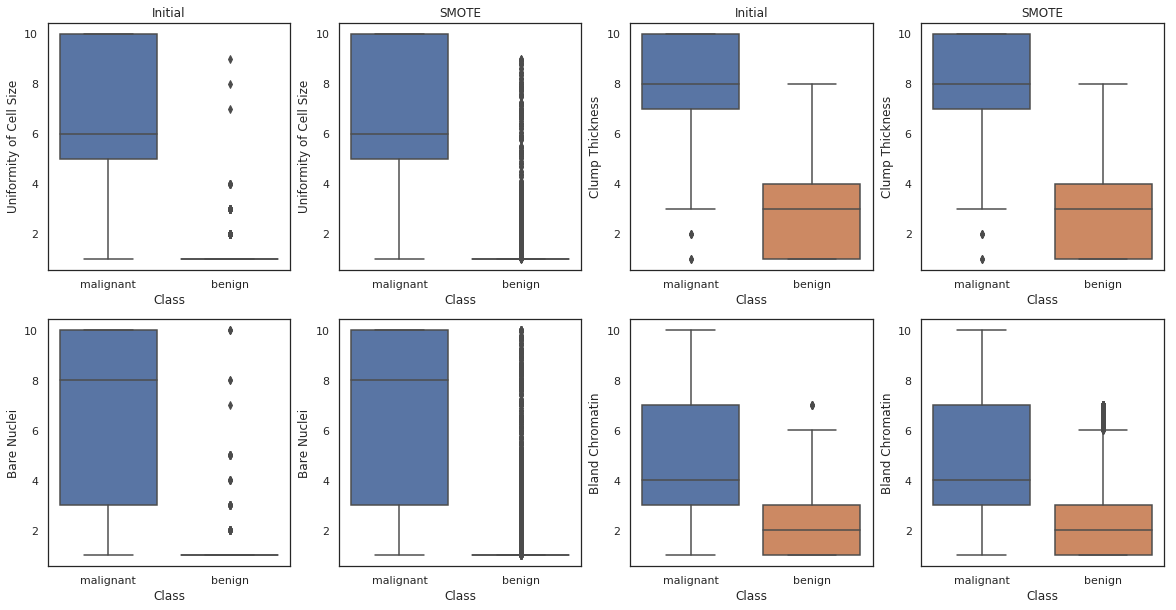

In [104]:
# verify in the initial data and SMOTE data
f, ax = plt.subplots(2, 4, figsize=(20, 10))
sns.boxplot(x='Class', y='Uniformity of Cell Size', data=feats, ax=ax[0, 0])
ax[0, 0].set_title('Initial')
sns.boxplot(x='Class', y='Uniformity of Cell Size', data=df_sm, ax=ax[0, 1])
ax[0, 1].set_title('SMOTE')
sns.boxplot(x='Class', y='Clump Thickness', data=feats, ax=ax[0, 2])
ax[0, 2].set_title('Initial')
sns.boxplot(x='Class', y='Clump Thickness', data=df_sm, ax=ax[0, 3])
ax[0, 3].set_title('SMOTE')
sns.boxplot(x='Class', y='Bare Nuclei', data=feats, ax=ax[1, 0])

sns.boxplot(x='Class', y='Bare Nuclei', data=df_sm, ax=ax[1, 1])

sns.boxplot(x='Class', y='Bland Chromatin', data=feats, ax=ax[1, 2])

sns.boxplot(x='Class', y='Bland Chromatin', data=df_sm, ax=ax[1, 3])

This can be cleaned up, but for now the features show pretty obvious difference.

### Partial Dependence Plots

In [26]:
# optional install if needed
#!pip install pdpbox

  Using cached https://files.pythonhosted.org/packages/87/23/ac7da5ba1c6c03a87c412e7e7b6e91a10d6ecf4474906c3e736f93940d49/PDPbox-0.2.0.tar.gz
  Stored in directory: /home/jim/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [31]:
feats['Class_le'] = le.fit_transform(feats['Class'])
feats.head()
df_pdp = feats.drop('Class', axis=1)
df_pdp.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class_le
0,7.0,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,1
1,6.0,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,1
2,8.0,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,1
3,7.0,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,1
4,5.0,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,1


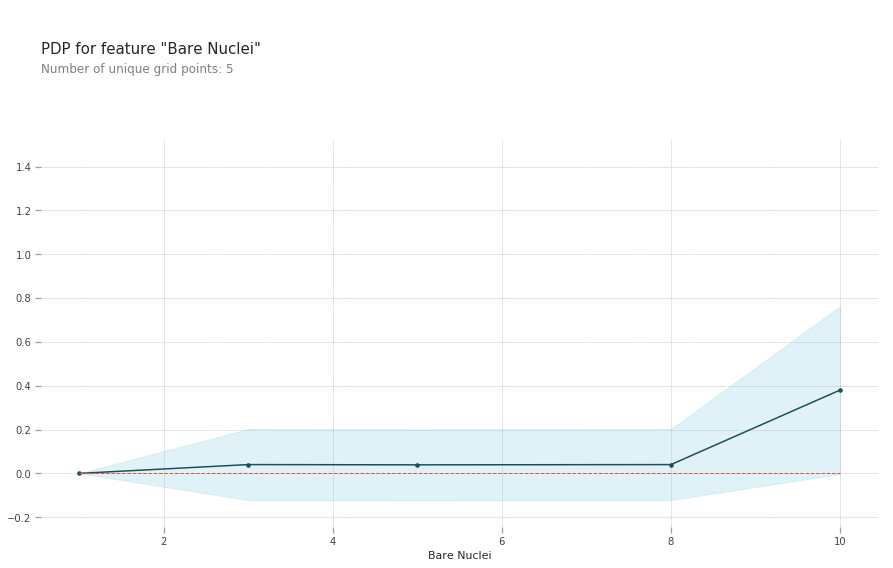

In [38]:
# visualize partial dependence plots
from pdpbox import pdp, info_plots

# see impact of Bare Nuclei
pdp_ = pdp.pdp_isolate(model=clf,
                       dataset=pd.DataFrame(X_test, columns=feats.drop(
                           ['Class_le', 'Class'], axis=1).columns),
                       model_features=feats.drop(
                           ['Class_le', 'Class'], axis=1).columns.tolist(),
                       feature='Bare Nuclei')
pdp.pdp_plot(pdp_, 'Bare Nuclei')
plt.show()

Bare Nuclei is most informative at scores of 10, when the uncertainty drops.

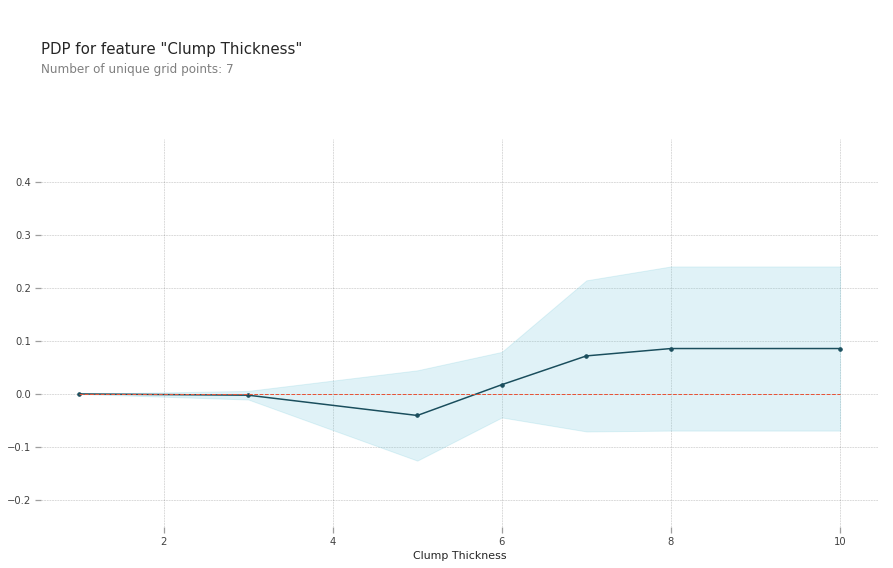

In [50]:
# see impact of Clump Thickness
pdp_ = pdp.pdp_isolate(model=clf,
                       dataset=pd.DataFrame(X_test, columns=feats.drop(
                           ['Class_le', 'Class'], axis=1).columns),
                       model_features=feats.drop(
                           ['Class_le', 'Class'], axis=1).columns.tolist(),
                       feature='Clump Thickness')
pdp.pdp_plot(pdp_, 'Clump Thickness')
plt.show()

Clump Thickness scores above 7 are predictive of malignancy, but there's a lot of uncertainty.

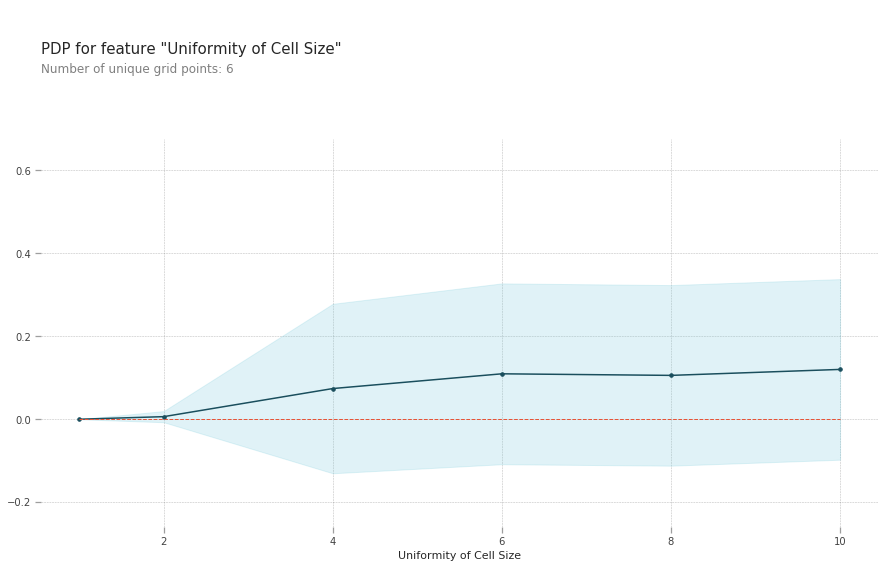

In [39]:
# see impact of Uniformity of Cell Size
pdp_ = pdp.pdp_isolate(model=clf,
                       dataset=pd.DataFrame(X_test, columns=feats.drop(
                           ['Class_le', 'Class'], axis=1).columns),
                       model_features=feats.drop(
                           ['Class_le', 'Class'], axis=1).columns.tolist(),
                       feature='Uniformity of Cell Size')
# plot it
pdp.pdp_plot(pdp_, 'Uniformity of Cell Size')
plt.show()

Uniformity of Cell Size has a clear signal very early, means most of the benigns have low scores. Has a high measure of uncertainty.

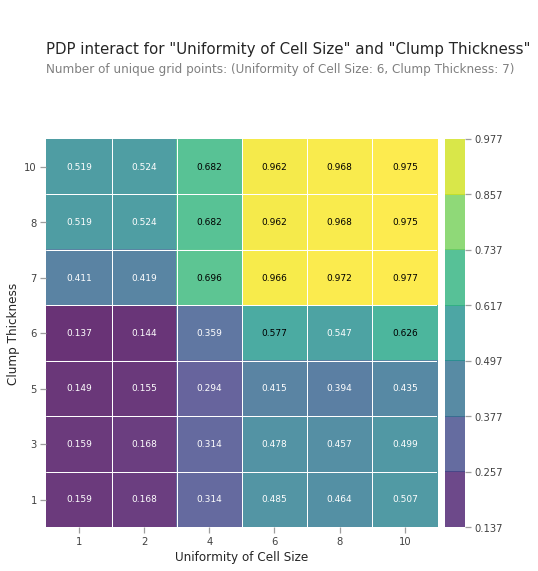

In [49]:
# impact of Uniformity of Cell Size vs Clump Thickness
features_to_plot = ['Uniformity of Cell Size', 'Clump Thickness']
inter_ = pdp.pdp_interact(model=clf,
                          dataset=pd.DataFrame(X_test, columns=feats.drop(
                              ['Class_le', 'Class'], axis=1).columns),
                          model_features=feats.drop(
                              ['Class_le', 'Class'], axis=1).columns.tolist(),
                          features=features_to_plot)

# grid
pdp.pdp_interact_plot(pdp_interact_out=inter_,
                      feature_names=features_to_plot, plot_type='grid')
plt.show()

This plot is really informative. 

This is using the SMOTE data, so we've got balanced (artifical) samples in both classes. 
0 == benign and 1 == malignant 

How to interpret this - samples having high scores for both Clump Thickness or Uniformity of Cell Size are extremely predictive of malignant class, whereas having low scores of both are predictive of benign. 

Having high score of Clump and low score for Size is not predictive, and vice versa. 

### SHAP values

In [51]:
# optional
#!pip install shap

  Using cached https://files.pythonhosted.org/packages/30/b3/866b0101cbd1829844c35964af68c14ba522a5cce7a1e8d0f7937411d910/shap-0.28.5.tar.gz
  Stored in directory: /home/jim/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


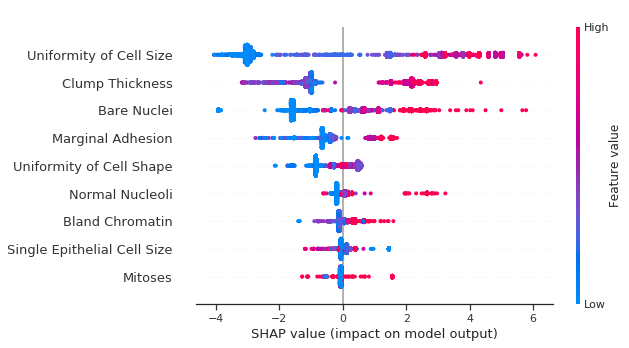

In [54]:
# visualize feature importances using SHAP
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(pd.DataFrame(X_test, columns=feats.drop(
    ['Class_le', 'Class'], axis=1).columns))

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=feats.drop(
    ['Class_le', 'Class'], axis=1).columns))

Clump Thickness is the clear winner here for a classification feature. Clump Thickness has a huge impact on the model output.

The top 4 look great, I'd prioritize them as:

Clump Thickness > Uniformity of Cell Size > Bare Nuclei

ELI5 results suggest the Bland Chromatin also significantly contribute to prediction, and although the magnitude of it's effect on SHAP values aren't that large, there does appear to be a strong separation by low and high features, so I'll include it as well.

### Minimal Features Classifier

In [135]:
def featureComboTest(top_feats):
    # run minimal model using combinations of top features and determine minimal features required for excellence.
    # define labels (y) and features (X)
    y = feats['Class'].values
    X = feats[top_feats].values

    # call SMOTE, use defauls first
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)

    # labelEncode SMOTE
    le = LabelEncoder()
    y_res_le = le.fit_transform(y_res)

    # fit model
    clf = GradientBoostingClassifier(random_state=42)  # use defaults

    # calculate CV score for AUC
    return cross_val_score(clf, X_res, y_res_le, cv=10, scoring='roc_auc')

In [185]:
feature_set

[('Clump Thickness',
  'Uniformity of Cell Size',
  'Bare Nuclei',
  'Marginal Adhesion'),
 ('Clump Thickness',
  'Uniformity of Cell Size',
  'Bare Nuclei',
  'Bland Chromatin'),
 ('Clump Thickness',
  'Uniformity of Cell Size',
  'Marginal Adhesion',
  'Bland Chromatin'),
 ('Clump Thickness', 'Bare Nuclei', 'Marginal Adhesion', 'Bland Chromatin'),
 ('Uniformity of Cell Size',
  'Bare Nuclei',
  'Marginal Adhesion',
  'Bland Chromatin')]

In [151]:
# define func to return possible combinations of features
from itertools import combinations
from tqdm import tqdm_notebook


def rSubset(arr, r):

    # return list of all subsets of length r
    # to deal with duplicate subsets use
    # set(list(combinations(arr, r)))
    return list(combinations(arr, r))


top_feats = ['Clump Thickness', 'Uniformity of Cell Size',
             'Bare Nuclei', 'Marginal Adhesion', 'Bland Chromatin']
num_feats = [1, 2, 3, 4]
feat_scores = {}
for i in tqdm_notebook(num_feats):
    feature_set = rSubset(top_feats, i)
    for j in tqdm_notebook(range(len(feature_set))):
        feat_scores[' + '.join(list(feature_set[j]))
                    ] = featureComboTest(list(feature_set[j]))

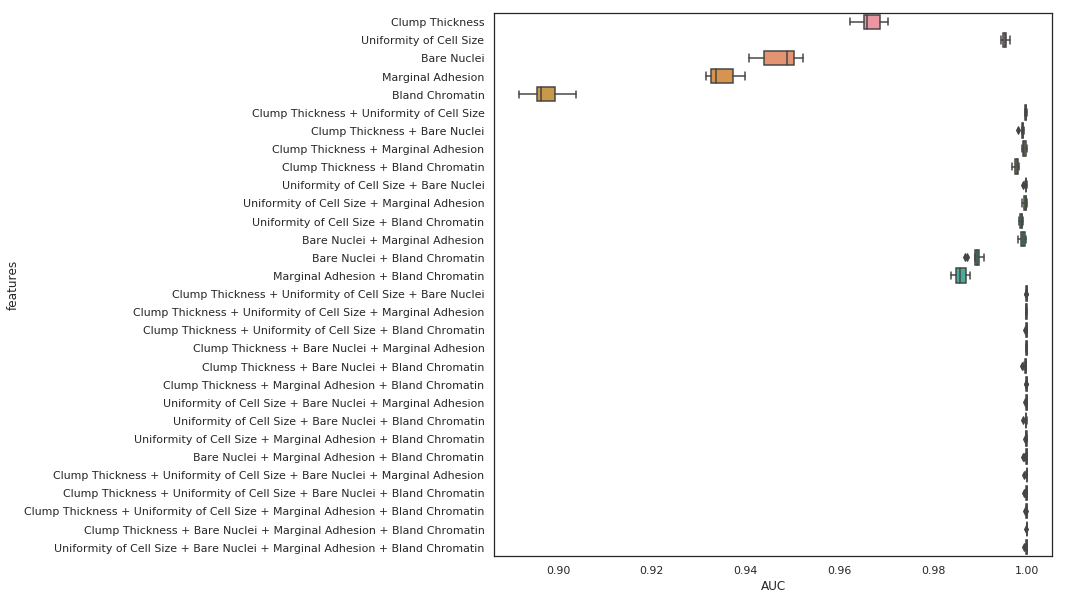

In [152]:
# cast to df, then melt for plotting
df_scores = pd.melt(pd.DataFrame(feat_scores),
                    var_name='features', value_name='AUC')

# make boxplot
plt.subplots(figsize=(10, 10))
sns.boxplot(y='features', x='AUC', data=df_scores)

In [174]:
df_scores.groupby('features').agg(['mean','std']).sort_values(('AUC', 'mean'), ascending=False)

AUC          
                                                        mean       std
features                                                              
Clump Thickness + Bare Nuclei + Marginal Adhesi...  0.999984  0.000030
Clump Thickness + Bare Nuclei + Marginal Adhesion   0.999946  0.000069
Clump Thickness + Marginal Adhesion + Bland Chr...  0.999944  0.000068
Clump Thickness + Uniformity of Cell Size + Bar...  0.999938  0.000068
Clump Thickness + Uniformity of Cell Size + Mar...  0.999931  0.000118
Uniformity of Cell Size + Bare Nuclei + Margina...  0.999926  0.000102
Clump Thickness + Uniformity of Cell Size + Mar...  0.999923  0.000076
Clump Thickness + Uniformity of Cell Size + Bla...  0.999919  0.000139
Uniformity of Cell Size + Marginal Adhesion + B...  0.999917  0.000085
Clump Thickness + Uniformity of Cell Size + Bar...  0.999916  0.000203
Uniformity of Cell Size + Bare Nuclei + Margina...  0.999900  0.000187
Clump Thickness + Uniformity of Cell Size + Bar...  0.999875  0.000223
Uniformity of Cell Size + Bare Nuclei + Bland C...  0.999845  0.000228
Bare Nuclei + Marginal Adhesion + Bland Chromatin   0.999834  0.000285
Clump Thickness + Uniformity of Cell Size           0.999832  0.000152
Uniformity of Cell Size + Bare Nuclei               0.999814  0.000207
Uniformity of Cell Size + Marginal Adhesion         0.999681  0.000303
Clump Thickness + Bare Nuclei + Bland Chromatin     0.999647  0.000301
Clump Thickness + Marginal Adhesion                 0.999502  0.000338
Bare Nuclei + Marginal Adhesion                     0.999158  0.000527
Clump Thickness + Bare Nuclei                       0.999045  0.000342
Uniformity of Cell Size + Bland Chromatin           0.998869  0.000282
Clump Thickness + Bland Chromatin                   0.997749  0.000536
Uniformity of Cell Size                             0.995377  0.000541
Bare Nuclei + Bland Chromatin                       0.989183  0.001250
Marginal Adhesion + Bland Chromatin                 0.985969  0.001317
Clump Thickness                                     0.966540  0.002779
Bare Nuclei                                         0.947512  0.003980
Marginal Adhesion                                   0.934961  0.002940
Bland Chromatin                                     0.897023  0.003713

## Conclusions and Next Steps

Based on the above, if I had to pick 1 feature I would pick 'Uniformity of Cell Size', as that performed fantastically alone.

After that, I would add 'Clump Thickness', as Clump Thickness + Uniformity of Cell Size were nearly perfect. Any additional features beyond those two couldn't hurt, but they won't improve the classifier either.

The output of the production model will be a probabilities for a given sample being classified as 'benign' or 'malignant'. With probabilities in hand, the dr. can discuss the results with the patient, and if needed show which measures contributed to their sample classification.